# Coherence Change Detection using IfgramStack.h5

**Created by: Marin Govorcin**

This notebook shows how we can use the Coherence timeseries [in inputs/ifgramStack.h5] for a Change\Damage Detection after natural hazard event, e.g. earthquakes, volcano eruption, flooding, etc..

Coherence Change Detection is obtained as a relative coherence loss between the "normal" pre-event coherence and co-event coherence. Pre-event coherence is calculated for two Synthetic Aperture Radar (SAR) SLCs acquired close before the event, whereas a co-event coherence is obtained between one before and one SAR SLC image.

*References:*

1. Yun, et al. (2015a): Rapid Damage Mapping for the 2015 Mw 7.8 Gorkha Earthquake Using Synthetic Aperture Radar Data fromCOSMO–SkyMed and ALOS-2 Satellites, Seismological Research Letters, https://pubs.geoscienceworld.org/srl/article/86/6/1549-1556/315478

2. Yun et al. (2015b): DAMAGE PROXY MAP FROM INTERFEROMETRIC SYNTHETIC APERTURE RADAR COHERENCE, United States Patent US 9.207,318 B2, https://patents.google.com/patent/US9207318

3. Washaya, et al. (2018): Coherence Change-Detection with Sentinel-1 for Natural and Anthropogenic Disaster Monitoring in Urban Areas, Remote Sensing, http://www.mdpi.com/2072-4292/10/7/1026

4. OPTIONAL: Stephenson et al. (2021): Deep Learning -based Damage Mapping with InSAR Coherence Time Series, IEEE Transactions on Geoscience and Remote Sensing, https://arxiv.org/pdf/2105.11544.pdf

* if you want to try it..some info on RNN can be found on https://www.tensorflow.org/guide/keras/rnn


In [1]:
# Import needed python modules
%matplotlib inline

import matplotlib.pyplot as plt
import os, sys, numpy as np
from skimage import exposure

#mintpy modules
from mintpy import view, geocode, save_kmz
from mintpy.objects import ifgramStack
from mintpy.utils import readfile, writefile, utils as ut

#Get coherence data before and during the defined event 
#                    (earthquake, volcano eruption, flooding)

def getCoherence(stack, eventDate, startDate=None):
    # Open ifgramStack.h5
    mintpyObj = ifgramStack(stack)
    mintpyObj.open()

    #Get the coherence date list
    date12List = mintpyObj.date12List
    
    # If startDate is not defined, use the first date in timeseries
    if startDate is None:
        startDate = date12List[0] 
    
    #initilize variables
    preEvent_ix = []
    coEvent_ix  = []
    
    # find coherence datasets before the Event from the start date (defined or begining of timeseries)
    # and  coherence dateset covering the Event: reference SAR acquisition before and secondary after the Event
    for ix,date12 in enumerate(date12List):
        if date12.split('_')[0] < eventDate and date12.split('_')[0] > startDate and date12.split('_')[1] < eventDate:
            preEvent_ix.append(ix)
        elif date12.split('_')[0] < eventDate and date12.split('_')[1] > eventDate:
            coEvent_ix.append(ix)
            
    # get coherence datesets from ifgramStack
    coherence = mintpyObj.read(datasetName='coherence')
    
    # images are in radar coordinate, mirrored, flip it left to right to view it as it should look
    return np.flip(coherence[preEvent_ix,:,:],axis=2), np.flip(coherence[coEvent_ix,:,:],axis=2), startDate.split('_')[0]
    


## Pre-event and Co-event coherence stack

open ifgramStack file: ifgramStack.h5
reading coherence data from file: /Users/govorcin/Projects/FernandinaSenDT128/mintpy/inputs/ifgramStack.h5 ...


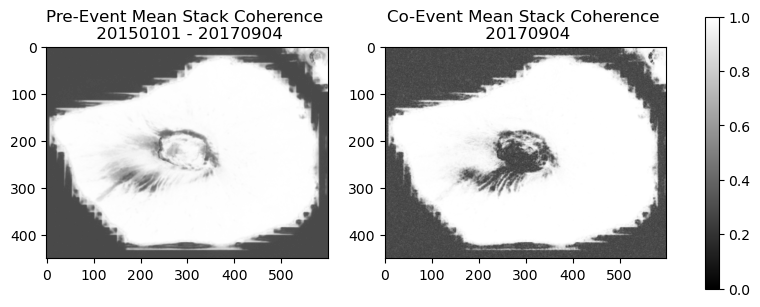

In [24]:
# Change directory to your work_dir
work_dir  = '/Users/govorcin/Projects/FernandinaSenDT128/mintpy'
os.chdir(work_dir)

# Define input parameters
stack     = os.path.join(work_dir,'inputs/ifgramStack.h5')
geom_file = os.path.join(work_dir,'inputs/geometryRadar.h5')

#Event: vulcano Fernandina eruption on Sep 04. 2017 
eventDate = '20170904' 
startDate = '20150101'

############################################################################################

# Read coherence stack from ifgramStack
pre_cohStack, co_cohStack, startDate = getCoherence(stack,eventDate,startDate)

# Calculate the mean pre-event and co-event stack coherence 
mpre_cohStack = np.mean(pre_cohStack,axis=0)
mco_cohStack  = np.mean(co_cohStack,axis=0)

# Plot Mean Pre-event and Co-event Coherence 
fig1, axs1 = plt.subplots(1, 2,figsize=(10,12),dpi=100)

im1 = axs1[0].imshow(mpre_cohStack, cmap='gray',clim=[0,1])
im2 = axs1[1].imshow(mco_cohStack, cmap='gray',clim=[0,1])

tx1 = f'Pre-Event Mean Stack Coherence \n {startDate} - {eventDate}'
tx2 = f'Co-Event Mean Stack Coherence \n {eventDate}'

axs1[0].title.set_text(tx1)
axs1[1].title.set_text(tx2)

fig1.colorbar(im1,ax=axs1[:],location='right',shrink=0.30)

## Coherence Change Calculation

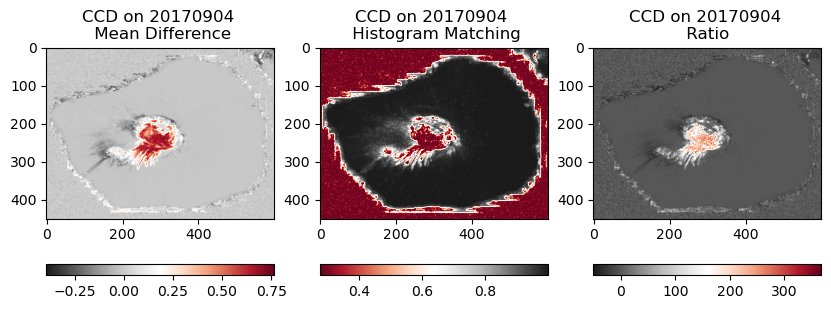

In [47]:
# Coherence Change Detection (CCD):  also known as Damage Proxy Map [Yun, et al.2015]

'''
We calculate CCD using three different approaches:
'''

# 1. As Difference: 
#    between mean pre_event stack coh.  - avg. co_event stack coh.

ccd_diff  = mpre_cohStack - mco_cohStack

# 2. Using histogram matching (Yun et al. 2015a and Yun et al. 2015b)
#    between mean pre_event stack coh.(ref image) and mean co_event stack coh. (matched image.)

ccd_histmatch = exposure.match_histograms(mco_cohStack, mpre_cohStack, multichannel=False)

# 3. As ratio between pre- & co-event coherence stack (Washaya, et al. 2018):

ccd_ratio = (mpre_cohStack - mco_cohStack) / mco_cohStack * 100

#######################################################################################
#######################################################################################

# Plot the Coherence Change Maps for Sep, 2017 eruption
fig2, axs2 = plt.subplots(1, 3,figsize=(10,12),dpi=100)
im3 = axs2[0].imshow(ccd_diff, cmap='RdGy_r')
im4 = axs2[1].imshow(ccd_histmatch, cmap='RdGy')
im5 = axs2[2].imshow(ccd_ratio, cmap='RdGy_r')

fig2.colorbar(im3,ax=axs2[0],location='bottom', pad=0.05)
fig2.colorbar(im4,ax=axs2[1],location='bottom', pad=0.05)
fig2.colorbar(im5,ax=axs2[2],location='bottom', pad=0.05)

tx3 = f'CCD on {eventDate} \n Mean Difference'
tx4 = f'CCD on {eventDate} \n Histogram Matching'
tx5 = f'CCD on {eventDate} \n Ratio '

axs2[0].title.set_text(tx3)
axs2[1].title.set_text(tx4)
axs2[2].title.set_text(tx5)


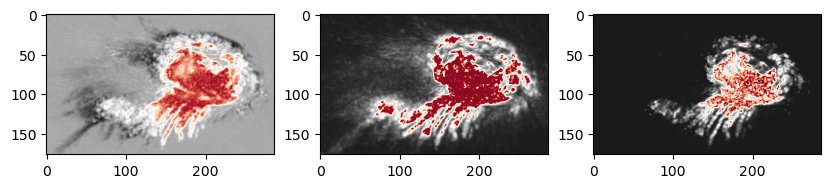

In [49]:
# LET'S ZOOM IN INTO THE AFFECTED AREA

#define the Area Of Interest (AOI) box ,this can be done interactively with matplotlib.widgets RectangleSelector
# list: x1, x2, y1 ,y2
box = [95,382, 154, 330]

######################################################
fig3, axs3 = plt.subplots(1, 3, figsize=(10,12),dpi=100)
im6 = axs3[0].imshow(ccd_diff[box[2]:box[3],box[0]:box[1]], cmap='RdGy_r',clim=[-0.3,0.8])
im7 = axs3[1].imshow(ccd_histmatch[box[2]:box[3],box[0]:box[1]], cmap='RdGy',clim=[0.25,1])
im8 = axs3[2].imshow(ccd_ratio[box[2]:box[3],box[0]:box[1]], cmap='RdGy_r',clim=[0,300])

### CCD refinement - Thresholding

Text(0.5, 0, 'AOI Avg. Coherence')

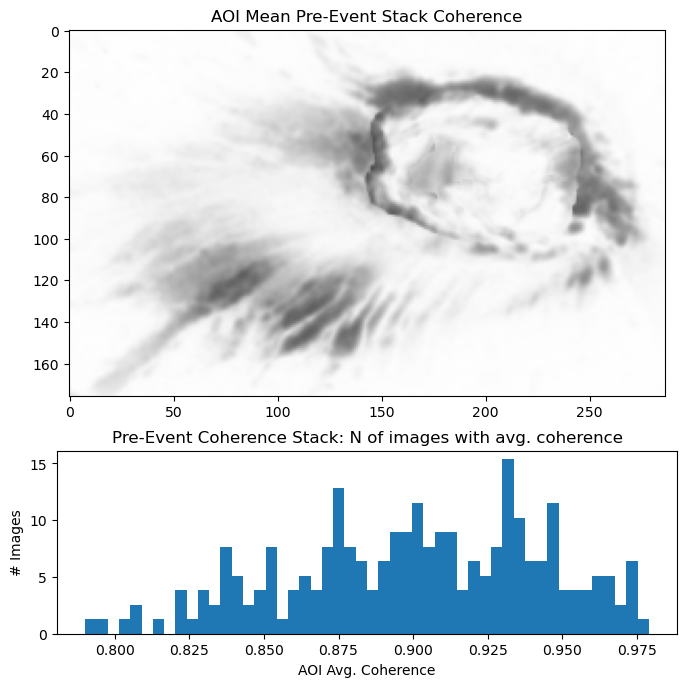

In [50]:
'''
Here we want to find the mean coherence in our AOI per each scene in the pre-event timeseries,
so we can drop the dates with some coherence changes, this will give us a "better" reference coherence
for calculation of coherence loss during the event
'''

# Get the mean coherence for each datatset in the defined AOI
mean_coh = []
for i,coh in enumerate(pre_cohStack):
    mean_coh.append(np.nanmean(coh[box[2]:box[3],box[0]:box[1]]))

# Plot 
fig4, axs4 = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 0.5]},figsize=(8,8),dpi=100)
cohBox=mpre_cohStack[box[2]:box[3],box[0]:box[1]]
im9 = axs4[0].imshow(cohBox,cmap='gray',clim=[0,1])
im10 = axs4[1].hist(mean_coh,bins=50,density=True)

axs4[0].title.set_text('AOI Mean Pre-Event Stack Coherence')
axs4[1].title.set_text('Pre-Event Coherence Stack: N of images with avg. coherence')
axs4[1].set_ylabel('# Images')
axs4[1].set_xlabel('AOI Avg. Coherence')

Number of pre-Event Datasets After Thresholding: 22


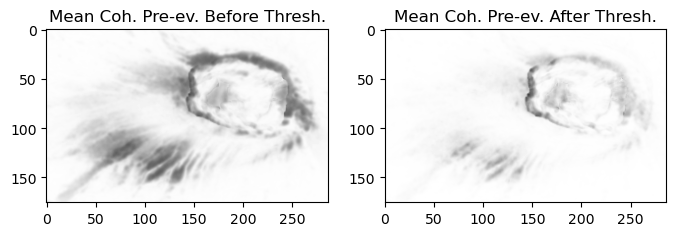

In [54]:
# Drop dates with mean cohrence below the defined threshold of 0.95

thresh = 0.95
ix = np.where(np.array(mean_coh) > thresh)

pre_cohStack2 = np.take(pre_cohStack,ix,axis=0)[0]
mpre_cohStack2 = np.nanmean(pre_cohStack2,axis=0)

#Lets make sure we have enough number of coherence images after thresholding
print(f'Number of pre-Event Datasets After Thresholding: {pre_cohStack2.shape[0]}')

# PLOT AOI
fig5, axs5 = plt.subplots(1, 2, figsize=(8,8),dpi=100)
im11 = axs5[0].imshow(mpre_cohStack[box[2]:box[3],box[0]:box[1]],cmap='gray', clim=[0,1])
im12 = axs5[1].imshow(mpre_cohStack2[box[2]:box[3],box[0]:box[1]],cmap='gray', clim=[0,1])

axs5[0].title.set_text('Mean Coh. Pre-ev. Before Thresh.')
axs5[1].title.set_text('Mean Coh. Pre-ev. After Thresh.')


### CCD after thresholding

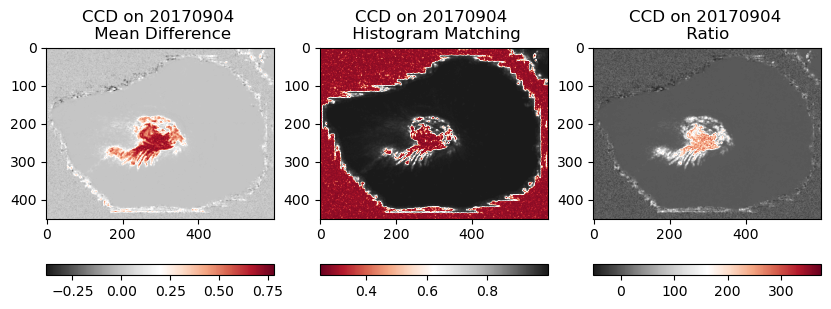

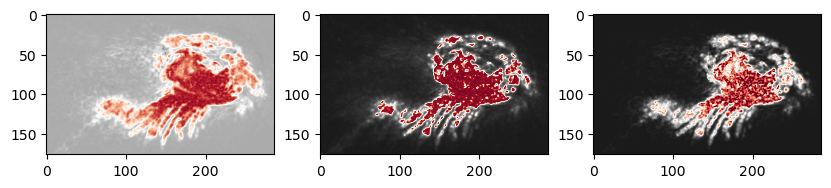

In [86]:
# Calculate and plot Coherence Change: 

# 1. As Difference: 
#    between mean pre_event stack coh.  - avg. co_event stack coh.

ccd_diff2  = mpre_cohStack2 - mco_cohStack

# 2. Using histogram matching (Yun et al. 2015a and Yun et al. 2015b)
#    between mean pre_event stack coh.(ref image) and mean co_event stack coh. (matched image.)

ccd_histmatch2 = exposure.match_histograms(mco_cohStack, mpre_cohStack2, multichannel=False)

# 3. As ratio between pre- & co-event coherence stack (Washaya, et al. 2018):

ccd_ratio2 = (mpre_cohStack2 - mco_cohStack) / mco_cohStack * 100

#######################################################################################
#######################################################################################

# Plot the Coherence Change Maps for Sep, 2017 eruption
fig6, axs6 = plt.subplots(1, 3,figsize=(10,12),dpi=100)
im13 = axs6[0].imshow(ccd_diff2, cmap='RdGy_r')
im14 = axs6[1].imshow(ccd_histmatch2, cmap='RdGy')
im15 = axs6[2].imshow(ccd_ratio2, cmap='RdGy_r')

fig6.colorbar(im13,ax=axs6[0],location='bottom', pad=0.05)
fig6.colorbar(im14,ax=axs6[1],location='bottom', pad=0.05)
fig6.colorbar(im15,ax=axs6[2],location='bottom', pad=0.05)

tx6 = f'CCD on {eventDate} \n Mean Difference'
tx7 = f'CCD on {eventDate} \n Histogram Matching'
tx8 = f'CCD on {eventDate} \n Ratio '

axs6[0].title.set_text(tx6)
axs6[1].title.set_text(tx7)
axs6[2].title.set_text(tx8)

#######################################################################################
# AOI
fig7, axs7 = plt.subplots(1, 3, figsize=(10,12),dpi=100)
im16 = axs7[0].imshow(ccd_diff2[box[2]:box[3],box[0]:box[1]], cmap='RdGy_r',clim=[-0.3,0.8])
im17 = axs7[1].imshow(ccd_histmatch2[box[2]:box[3],box[0]:box[1]], cmap='RdGy',clim=[0.25,1])
im18 = axs7[2].imshow(ccd_ratio2[box[2]:box[3],box[0]:box[1]], cmap='RdGy_r',clim=[0,280])


# CCD Detection Masking and Exporting Results to .h5

delete exsited file: cohChange_Fernandina-0917.h5
create HDF5 file: cohChange_Fernandina-0917.h5 with w mode
create dataset /CCD_diff-092017  of float32    in size of (450, 600)           with compression=None
create dataset /CCD_hist-092017  of float64    in size of (450, 600)           with compression=None
create dataset /CCD_ratio-092017 of float32    in size of (450, 600)           with compression=None
finished writing to cohChange_Fernandina-0917.h5


'cohChange_Fernandina-0917.h5'

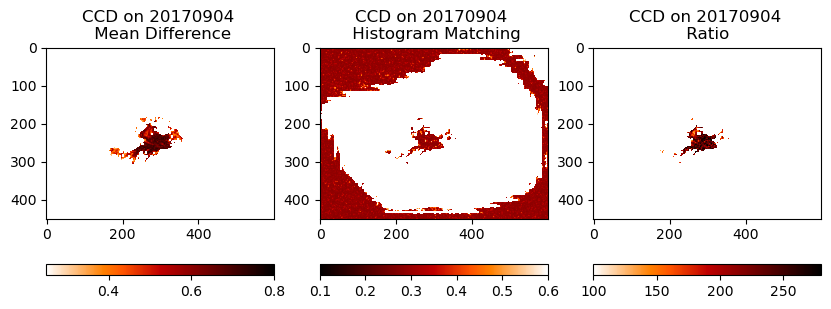

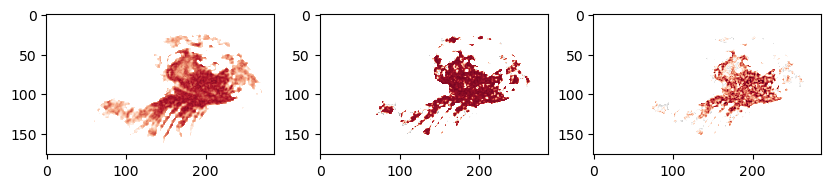

In [87]:
#######################################################################################
##########################       MASKING       ########################################
#######################################################################################
'''
Mask the not representative pixels values for the coherence change / damage
'''

ccd_diff2 = np.ma.filled(np.ma.masked_where(ccd_diff2<0.25,ccd_diff2),fill_value=np.nan)

ccd_histmatch2 = np.ma.filled(np.ma.masked_where(ccd_histmatch2>0.8,ccd_histmatch2),fill_value=np.nan)

ccd_ratio2 = np.ma.filled(np.ma.masked_where(ccd_ratio2<100,ccd_ratio2),fill_value=np.nan)

# Plot the Coherence Change Maps for Sep, 2017 eruption
fig7, axs7 = plt.subplots(1, 3,figsize=(10,12),dpi=100)
im19 = axs7[0].imshow(ccd_diff2, cmap='gist_heat_r',clim=[0.25,0.8])
im20 = axs7[1].imshow(ccd_histmatch2, cmap='gist_heat',clim=[0.1,0.6])
im21 = axs7[2].imshow(ccd_ratio2, cmap='gist_heat_r',clim=[100,280])

fig7.colorbar(im19,ax=axs7[0],location='bottom', pad=0.05)
fig7.colorbar(im20,ax=axs7[1],location='bottom', pad=0.05)
fig7.colorbar(im21,ax=axs7[2],location='bottom', pad=0.05)

tx9 = f'CCD on {eventDate} \n Mean Difference'
tx10 = f'CCD on {eventDate} \n Histogram Matching'
tx11 = f'CCD on {eventDate} \n Ratio '

axs7[0].title.set_text(tx9)
axs7[1].title.set_text(tx10)
axs7[2].title.set_text(tx11)

#AOI
fig8, axs8 = plt.subplots(1, 3, figsize=(10,12),dpi=100)
im22 = axs8[0].imshow(ccd_diff2[box[2]:box[3],box[0]:box[1]], cmap='RdGy_r',clim=[-0.3,0.8])
im23 = axs8[1].imshow(ccd_histmatch2[box[2]:box[3],box[0]:box[1]], cmap='RdGy',clim=[0.25,1])
im24 = axs8[2].imshow(ccd_ratio2[box[2]:box[3],box[0]:box[1]], cmap='RdGy_r',clim=[0,300])

#######################################################################################
########################       WRITE RESULTS       ####################################
#######################################################################################

# Write the results to h5
attr = readfile.read_attribute(stack)

dsDict = {}
dsDict['CCD_diff-092017'] = np.fliplr(ccd_diff2)
dsDict['CCD_hist-092017'] = np.fliplr(ccd_histmatch2)
dsDict['CCD_ratio-092017'] = np.fliplr(ccd_ratio2)

attr['FILE_TYPE'] = 'coherence'
attr['PROCESOR'] = 'ISCE'
attr['LENGTH'] = CCD.shape[0]
attr['WIDTH'] = CCD.shape[1]

writefile.write(dsDict,out_file='cohChange_Fernandina-0917.h5',metadata=attr)

## GEOCODE RESULTS with mintpy.geocode.py

In [69]:
geocode.main(f'cohChange_Fernandina-0917.h5 -l {geom_file}'.split())

number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/govorcin/Projects/FernandinaSenDT128/mintpy/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000769347151563003, 0.0006114087240126774)
output area extent in (S, N, W, E) in degree: (-0.5497810245555865, -0.20357480635223515, -91.70539145875654, -91.33854622434893)
output file row / column number: (450, 600)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: cohChange_Fernandina-0917.h5
update REF_LAT/LON/Y/X
--------------------------------------------------
grab dataset structure from ref_file: cohChange_Fernandina-0917.h5
create HDF5 file: geo_cohChange_Fernandina-0917.h5 with w mode
create dataset  : CCD_diff-092017  of float32                   in size of (450, 600)           with compression = None
create dataset  : CCD_hist-092017  of float64                   in size of 

## Export geocoded CCD results to KMZ

data   coverage in y/x: (0, 0, 600, 450)
subset coverage in y/x: (0, 0, 600, 450)
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 0/0/600/450
update Y/X_FIRST
update REF_Y/X
Unrecognized phase/length unit: ccd
colormap: jet
plotting data ...
figure size : [12.72, 12.00]
show reference point
writing /Users/govorcin/Projects/FernandinaSenDT128/mintpy/geo_cohChange_CCD_diff-092017.png with dpi=600
writing /Users/govorcin/Projects/FernandinaSenDT128/mintpy/geo_cohChange_CCD_diff-092017_cbar.png
writing /Users/govorcin/Projects/FernandinaSenDT128/mintpy/geo_cohChange_CCD_diff-092017.kml
remove /Users/govorcin/Projects/FernandinaSenDT128/mintpy/geo_cohChange_CCD_diff-092017.kml
remove /Users/govorcin/Projects/FernandinaSenDT128/mintpy/geo_cohChange_CCD_diff-092017.png
remove /Users/govorcin/Projects/FernandinaSenDT128/mintpy/geo_cohChange_CCD_diff-092017_cbar.png
merged all files to /Users/govorcin/Projects/FernandinaSenDT128/mintpy/geo_cohChange_CCD_diff-092017.kmz


'/Users/govorcin/Projects/FernandinaSenDT128/mintpy/geo_cohChange_CCD_diff-092017.kmz'

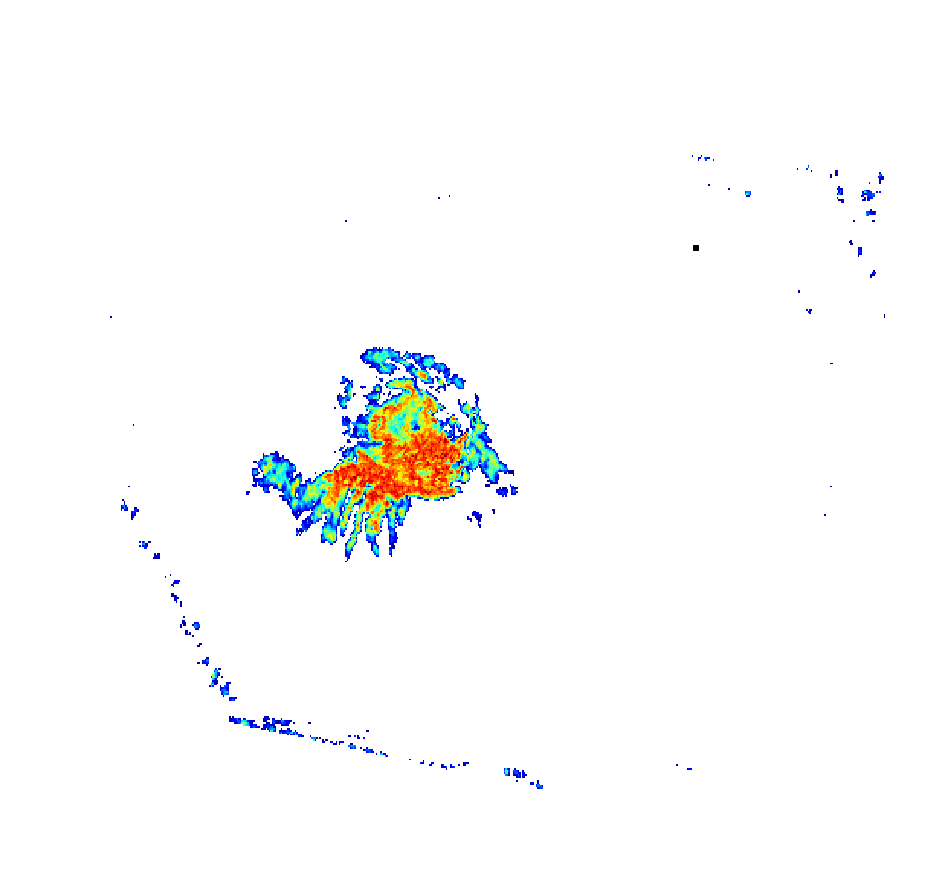

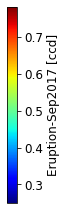

In [81]:
save_kmz.main('geo_cohChange_Fernandina-0917.h5 CCD_diff-092017 --cbar-label Eruption-Sep2017 -u CCD'.split())

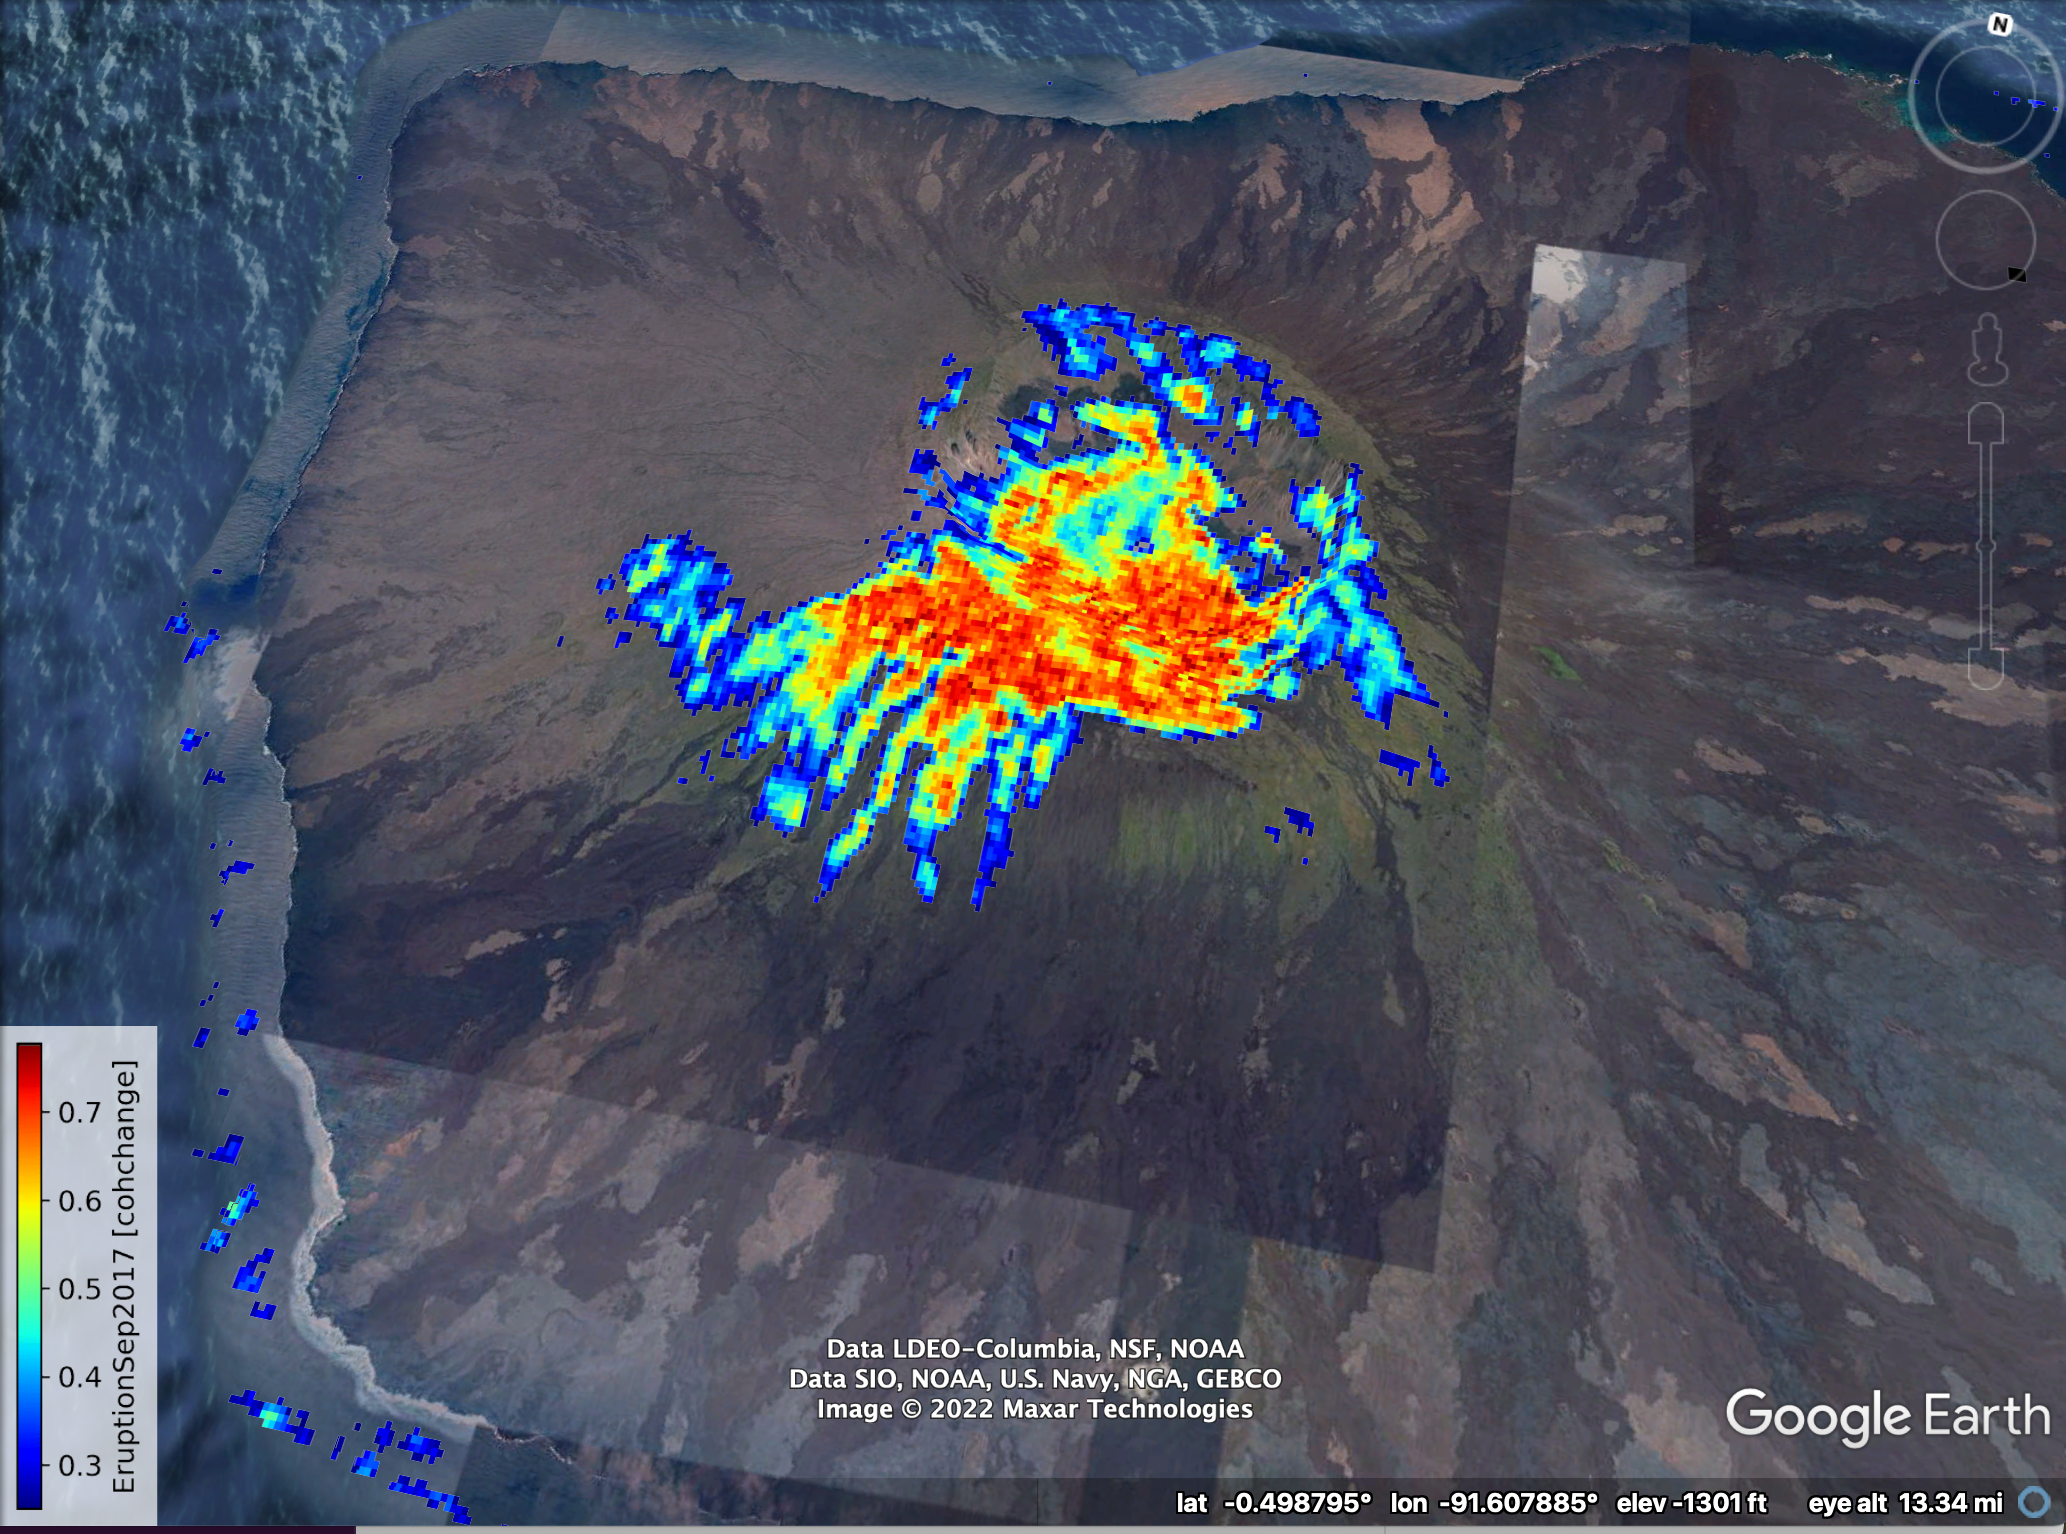

In [218]:
from IPython.display import Image

Image("Fernandina_eruptionSep2017.png")